In [36]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [37]:
# Cell 2: Load and Preprocess the Data
file_path = 'to code - Copy - 2.xlsx'  # Update to your actual file path
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Scale numerical columns to [0, 1]
scalers = {}
scaled_data = data.copy()

for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        scaler = MinMaxScaler()
        scaled_data[[col]] = scaler.fit_transform(data[[col]])
        scalers[col] = scaler

print("Data loaded and scaled successfully.")
print(f"Scaled data shape: {scaled_data.shape}")


Data loaded and scaled successfully.
Scaled data shape: (12175, 7)


In [38]:
# Cell 3: Define Variational Autoencoder (VAE) Model with Standalone Loss Function

# Check scaled data shape
if scaled_data is None or scaled_data.shape[1] == 0:
    raise ValueError("Scaled data is invalid. Please check the preprocessing step.")
print(f"Scaled data shape: {scaled_data.shape}")

# Dimensions
original_dim = scaled_data.shape[1]  # Number of features
latent_dim = 2  # Dimensionality of latent space
intermediate_dim = 64  # Hidden layer size

# Encoder
inputs = Input(shape=(original_dim,), name="encoder_input")
h = Dense(intermediate_dim, activation="relu", name="encoder_dense")(inputs)
z_mean = Dense(latent_dim, name="z_mean")(h)
z_log_var = Dense(latent_dim, name="z_log_var")(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
print("Encoder summary:")
encoder.summary()

# Decoder
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation="relu", name="decoder_dense")(decoder_input)
decoder_output = Dense(original_dim, activation="sigmoid", name="decoder_output")(decoder_h)

# Decoder model
decoder = Model(decoder_input, decoder_output, name="decoder")
print("Decoder summary:")
decoder.summary()

# Full VAE model
outputs = decoder(z)
vae = Model(inputs, outputs, name="vae")

# Define VAE loss function
def vae_loss(inputs, outputs):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_sum(tf.square(inputs - outputs), axis=1)
    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    # Total loss
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile the VAE with the custom loss
vae.compile(optimizer='adam', loss=vae_loss)

print("VAE Model Summary:")
vae.summary()


Scaled data shape: (12175, 7)
Encoder summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_dense (Dense)         │ (None, 64)                │             512 │ encoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 2)                 │             130 │ encoder_dense[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 2)                 │             130 │ encoder_dense[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z (Lambda)                    │ (None, 2)                 │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 772 (3.02 KB)

 Trainable params: 772 (3.02 KB)

 Non-trainable params: 0 (0.00 B)

Decoder summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense (Dense)                │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Dense)               │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 647 (2.53 KB)

 Trainable params: 647 (2.53 KB)

 Non-trainable params: 0 (0.00 B)

VAE Model Summary:


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_dense (Dense)         │ (None, 64)                │             512 │ encoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 2)                 │             130 │ encoder_dense[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 2)                 │             130 │ encoder_dense[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z (Lambda)                    │ (None, 2)                 │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder (Functional)          │ (None, 7)                 │             647 │ z[0][0]                    │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,419 (5.54 KB)

 Trainable params: 1,419 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Debug: Check the shape of the input data
print(f"Shape of scaled_data_array: {scaled_data_array.shape}")


Shape of scaled_data_array: (12175, 7)


In [40]:
# Ensure data is in float format
scaled_data_array = scaled_data_array.astype('float32')
print(f"Data type of scaled_data_array: {scaled_data_array.dtype}")


Data type of scaled_data_array: float32


In [41]:
print(f"Shape of scaled_data_array: {scaled_data_array.shape}")
print(f"Data type: {scaled_data_array.dtype}")


Shape of scaled_data_array: (12175, 7)
Data type: float32


In [42]:
print(f"Any NaN in scaled_data_array: {np.isnan(scaled_data_array).any()}")
print(f"Any Inf in scaled_data_array: {np.isinf(scaled_data_array).any()}")


Any NaN in scaled_data_array: False
Any Inf in scaled_data_array: False


In [43]:
vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_dense (Dense)         │ (None, 64)                │             512 │ encoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 2)                 │             130 │ encoder_dense[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 2)                 │             130 │ encoder_dense[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z (Lambda)                    │ (None, 2)                 │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder (Functional)          │ (None, 7)                 │             647 │ z[0][0]                    │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,419 (5.54 KB)

 Trainable params: 1,419 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
from tensorflow.keras import backend as K

# Custom VAE Loss Layer
class VAELossLayer(tf.keras.layers.Layer):
    def call(self, inputs, outputs, z_mean, z_log_var):
        # Reconstruction loss
        reconstruction_loss = K.sum(K.square(inputs - outputs), axis=-1)
        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        # Add losses to the model
        self.add_loss(K.mean(reconstruction_loss + kl_loss))
        return outputs  # Pass-through the outputs

# Define Variational Autoencoder
outputs = VAELossLayer()(inputs, outputs, z_mean, z_log_var)
vae = Model(inputs, outputs, name="vae_with_custom_loss")

# Compile VAE
vae.compile(optimizer='adam')
print("VAE Model Summary:")
vae.summary()


VAE Model Summary:


Model: "vae_with_custom_loss"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_dense (Dense)         │ (None, 64)                │             512 │ encoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 2)                 │             130 │ encoder_dense[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 2)                 │             130 │ encoder_dense[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z (Lambda)                    │ (None, 2)                 │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder (Functional)          │ (None, 7)                 │             647 │ z[0][0]                    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vae_loss_layer (VAELossLayer) │ (None, 7)                 │               0 │ encoder_input[0][0],       │
│                               │                           │                 │ decoder[0][0],             │
│                               │                           │                 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,419 (5.54 KB)

 Trainable params: 1,419 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Ensure the input data is float32
scaled_data_array = scaled_data.values.astype('float32')

# Train the VAE
history = vae.fit(
    scaled_data_array,  # Input data
    scaled_data_array,  # Target data
    epochs=50,          # Number of epochs
    batch_size=32,      # Batch size
    validation_split=0.1,  # Use 10% of data for validation
    verbose=2           # Show detailed output
)

print("VAE training complete.")


Epoch 1/50
343/343 - 2s - 6ms/step - loss: 0.4853 - val_loss: 0.3638
Epoch 2/50
343/343 - 0s - 1ms/step - loss: 0.3740 - val_loss: 0.3577
Epoch 3/50
343/343 - 0s - 871us/step - loss: 0.3720 - val_loss: 0.3561
Epoch 4/50
343/343 - 0s - 899us/step - loss: 0.3717 - val_loss: 0.3557
Epoch 5/50
343/343 - 0s - 1ms/step - loss: 0.3716 - val_loss: 0.3559
Epoch 6/50
343/343 - 0s - 940us/step - loss: 0.3713 - val_loss: 0.3555
Epoch 7/50
343/343 - 0s - 943us/step - loss: 0.3715 - val_loss: 0.3556
Epoch 8/50
343/343 - 0s - 1ms/step - loss: 0.3713 - val_loss: 0.3568
Epoch 9/50
343/343 - 0s - 1ms/step - loss: 0.3714 - val_loss: 0.3558
Epoch 10/50
343/343 - 0s - 859us/step - loss: 0.3710 - val_loss: 0.3549
Epoch 11/50
343/343 - 0s - 871us/step - loss: 0.3711 - val_loss: 0.3554
Epoch 12/50
343/343 - 0s - 1ms/step - loss: 0.3711 - val_loss: 0.3570
Epoch 13/50
343/343 - 0s - 881us/step - loss: 0.3713 - val_loss: 0.3548
Epoch 14/50
343/343 - 0s - 870us/step - loss: 0.3714 - val_loss: 0.3556
Epoch 15/50
3

In [47]:
# Cell 4: Train the VAE
scaled_data_array = scaled_data.values.astype('float32')  # Ensure data is float32

# Debug: Validate the data
print(f"Shape of scaled_data_array: {scaled_data_array.shape}")
print(f"Data type: {scaled_data_array.dtype}")

# Train the VAE
try:
    history = vae.fit(
        scaled_data_array,  # Input data
        scaled_data_array,  # Target data (autoencoders use the same data for input and output)
        epochs=50,          # Number of epochs
        batch_size=32,      # Batch size
        validation_split=0.1,  # Use 10% of the data for validation
        verbose=2           # Print training progress
    )
    print("VAE training complete.")
except Exception as e:
    print(f"Error during training: {e}")


Shape of scaled_data_array: (12175, 7)
Data type: float32
Epoch 1/50
343/343 - 0s - 1ms/step - loss: 0.3710 - val_loss: 0.3551
Epoch 2/50
343/343 - 0s - 919us/step - loss: 0.3709 - val_loss: 0.3549
Epoch 3/50
343/343 - 0s - 1ms/step - loss: 0.3709 - val_loss: 0.3551
Epoch 4/50
343/343 - 0s - 883us/step - loss: 0.3709 - val_loss: 0.3548
Epoch 5/50
343/343 - 0s - 895us/step - loss: 0.3710 - val_loss: 0.3549
Epoch 6/50
343/343 - 0s - 1ms/step - loss: 0.3709 - val_loss: 0.3556
Epoch 7/50
343/343 - 0s - 1ms/step - loss: 0.3707 - val_loss: 0.3542
Epoch 8/50
343/343 - 0s - 887us/step - loss: 0.3710 - val_loss: 0.3552
Epoch 9/50
343/343 - 0s - 892us/step - loss: 0.3707 - val_loss: 0.3554
Epoch 10/50
343/343 - 0s - 1ms/step - loss: 0.3710 - val_loss: 0.3552
Epoch 11/50
343/343 - 0s - 882us/step - loss: 0.3709 - val_loss: 0.3551
Epoch 12/50
343/343 - 0s - 885us/step - loss: 0.3707 - val_loss: 0.3543
Epoch 13/50
343/343 - 0s - 908us/step - loss: 0.3709 - val_loss: 0.3548
Epoch 14/50
343/343 - 0s 

In [48]:
# Cell 5: Generate Synthetic Data and Post-Process

# Step 1: Sample random latent vectors
num_samples = len(scaled_data)  # Generate the same number of samples as the original data
latent_samples = np.random.normal(size=(num_samples, latent_dim))  # Random samples in latent space

# Step 2: Decode the latent samples
synthetic_scaled_data = decoder.predict(latent_samples)  # Decoder output in scaled space

# Step 3: Transform synthetic data back to the original scale
synthetic_data = pd.DataFrame(columns=data.columns)  # Prepare a DataFrame for synthetic data

for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        # Inverse scale numeric columns
        synthetic_data[col] = scalers[col].inverse_transform(
            synthetic_scaled_data[:, data.columns.get_loc(col)].reshape(-1, 1)
        ).flatten()
    else:
        # For non-numeric columns, sample values from the original data
        synthetic_data[col] = data[col].sample(n=num_samples, replace=True).values

# Ensure data types match the original dataset
synthetic_data = synthetic_data.astype(data.dtypes)

# Step 4: Save or preview the synthetic data
print("Synthetic data generation complete.")
print(synthetic_data.head())


381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
Synthetic data generation complete.
   P_SEXE  P_GRAGE  D_ORIXCOOR  D_ORIYCOOR  D_DESTXCOOR  D_DESTYCOOR  D_HREDE
0       1        9      292527     5020841       290698      5026939     1328
1       1        9      292482     5013239       292100      5012999     1337
2       1        8      292267     5011551       292496      5009072     1337
3       1        8      296639     5034511       291981      5027546     1300
4       1        8      292117     5023489       293403      5023364     1323


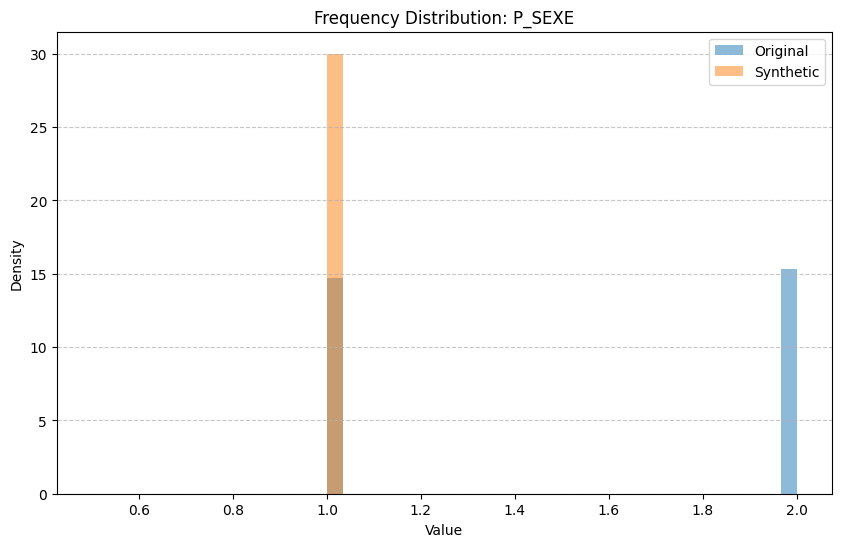

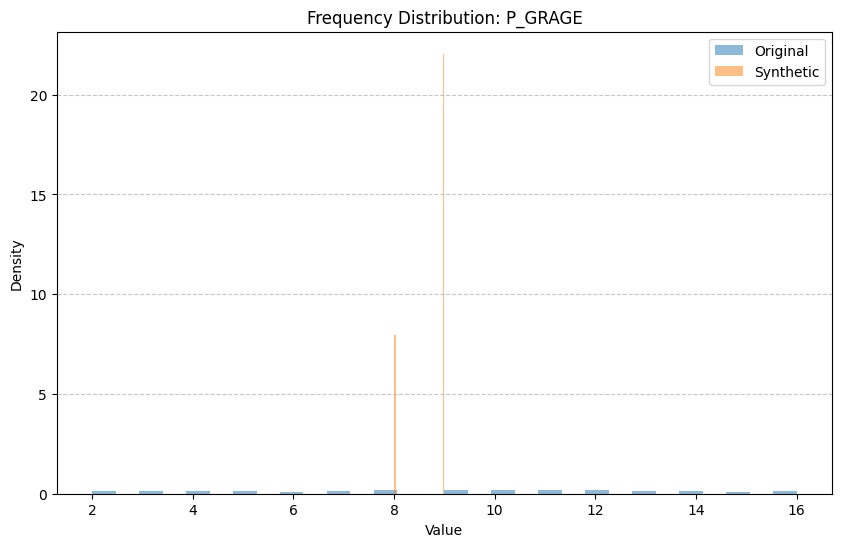

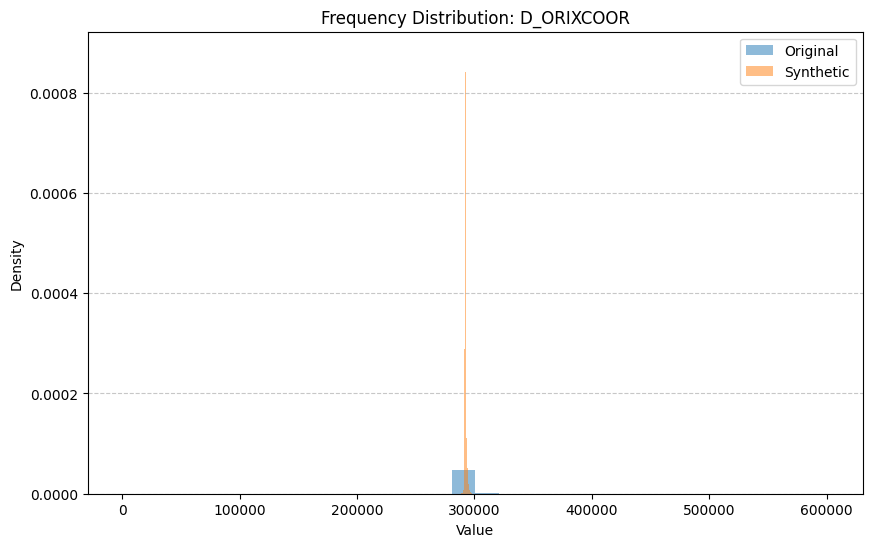

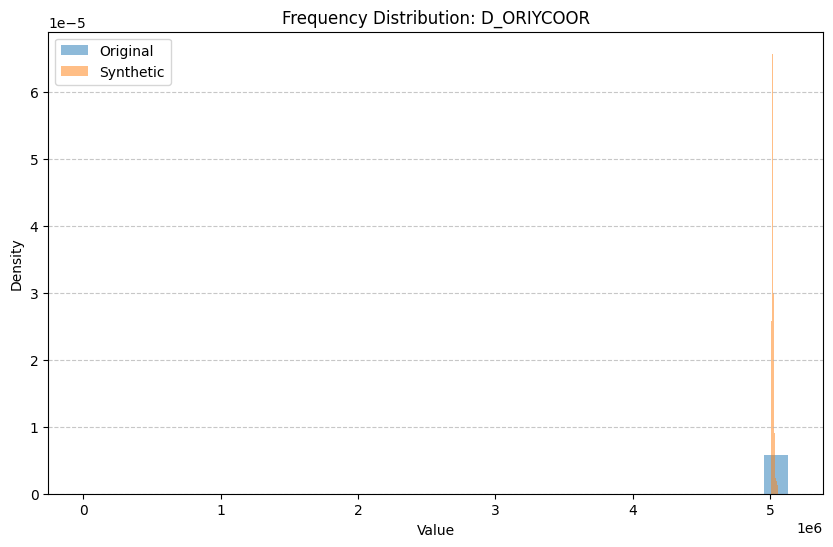

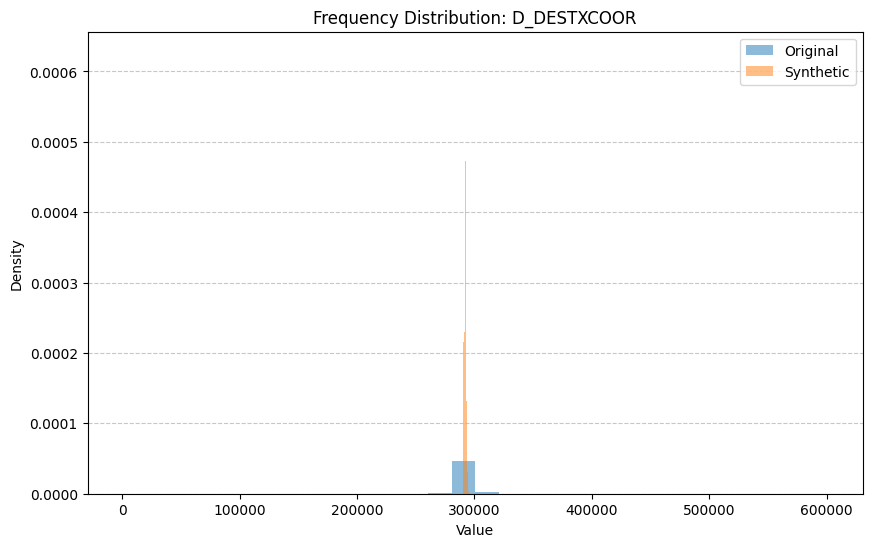

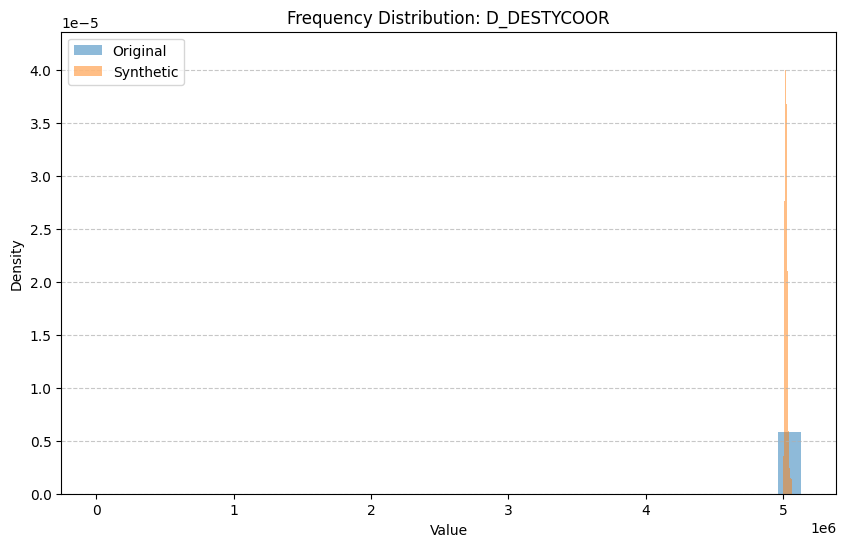

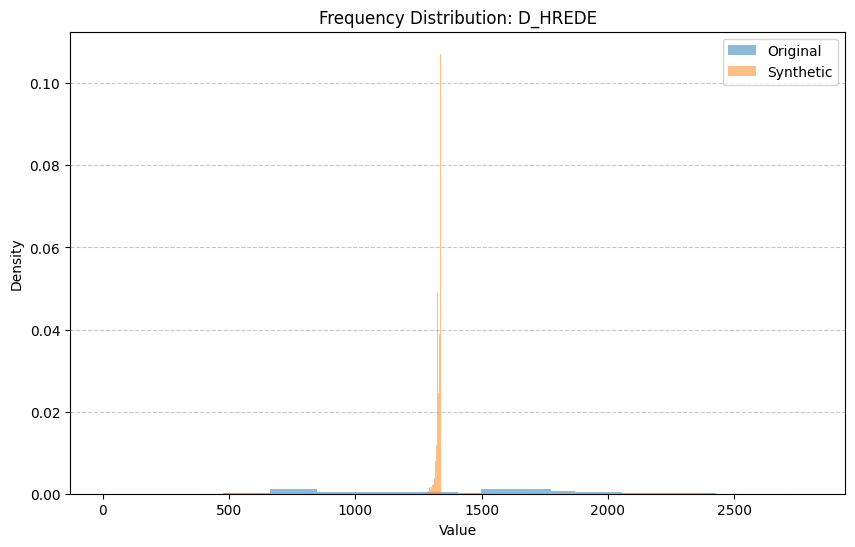

In [49]:
# Cell 6: Visualize and Compare Frequency Distributions
import matplotlib.pyplot as plt

def plot_frequency_comparison(original, synthetic, column_name):
    """
    Plot histograms to compare frequency distributions of original and synthetic data.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(original, bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(synthetic, bins=30, alpha=0.5, label='Synthetic', density=True)
    plt.title(f'Frequency Distribution: {column_name}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot comparisons for each numeric column
for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        plot_frequency_comparison(data[column], synthetic_data[column], column)


In [50]:
synthetic_data.to_csv("synthetic_data.csv", index=False)
print("Synthetic data saved to 'synthetic_data.csv'.")


Synthetic data saved to 'synthetic_data.csv'.


In [51]:
from scipy.stats import ks_2samp

for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        stat, p_value = ks_2samp(data[col], synthetic_data[col])
        print(f"{col}: KS Statistic = {stat:.4f}, P-Value = {p_value:.4f}")


P_SEXE: KS Statistic = 0.5106, P-Value = 0.0000
P_GRAGE: KS Statistic = 0.4727, P-Value = 0.0000
D_ORIXCOOR: KS Statistic = 0.3455, P-Value = 0.0000
D_ORIYCOOR: KS Statistic = 0.9349, P-Value = 0.0000
D_DESTXCOOR: KS Statistic = 0.3715, P-Value = 0.0000
D_DESTYCOOR: KS Statistic = 0.9023, P-Value = 0.0000
D_HREDE: KS Statistic = 0.5319, P-Value = 0.0000
